### Apply PureTSM Model on Brussels Mobility Data

In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import  matplotlib.pyplot as plt

import pickle
import xgboost as xgb
import networkx as nx

In [2]:
# define the list of detectors, streets, and directions of valid channels
lst_detectors = ['ARL_103', 'ARL_203',  'BAI_TD1', 'BAI_TD2', 'BEL_TD4', 'BEL_TD5', 'BOT_TD2',    
                 'BE_TD1', 'LOU_TD1', 'LOU_TD2', 'MAD_103', 'MAD_203', 'ROG_TD1', 'ROG_TD2']   # 14 detectors

# Import the dataframe from the pickle file
df = pd.read_pickle('../data/brussels_traffic_counting_20200122.pkl')

# Create the continuous series of timestamps
start_datetime_str = '2020/01/14 00:01'
end_datetime_str = '2020/01/22 00:01'

rush_hours = ['07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '15:15', '15:30', '15:45', '16:00',
              '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '18:00']

merge_column_name = 'start_time'
cols_to_drop = ['speed', 'occupancy', 'end_time']

num_timesteps = 8  # history window: 2 hours
pred_steps = 1  # prediction ahead: half an hour

In [3]:
df_dropped = df.drop(cols_to_drop, axis=1)
df_dropped.head()

,detector_code,count,start_time
0,ARL_103,34,2020/01/10 13:52
1,ARL_203,36,2020/01/10 13:52
2,BAI_TD1,23,2020/01/10 13:52
3,BAI_TD2,20,2020/01/10 13:52
4,BEL_TD4,26,2020/01/10 13:52


In [4]:
def create_series_timestamps(start_datetime_str, end_datetime_str, column_name):
    datetime_start = datetime.strptime(start_datetime_str, '%Y/%m/%d %H:%M')
    datetime_end = datetime.strptime(end_datetime_str, '%Y/%m/%d %H:%M')

    # returns a timedelta object
    delta = datetime_end - datetime_start
    num_seconds = delta.days * 24 * 3600 + delta.seconds

    # returns minutes
    num_minutes = divmod(num_seconds, 60)[0]

    date_list = [(datetime_start + timedelta(minutes=x)).strftime("%Y/%m/%d %H:%M") for x in
                 range(num_minutes)]
    df_timestamps = pd.DataFrame(date_list, columns=[column_name])

    return df_timestamps

df_timestamps = create_series_timestamps(start_datetime_str, end_datetime_str, merge_column_name)

In [5]:
df_timestamps.head()

,start_time
0,2020/01/14 00:01
1,2020/01/14 00:02
2,2020/01/14 00:03
3,2020/01/14 00:04
4,2020/01/14 00:05


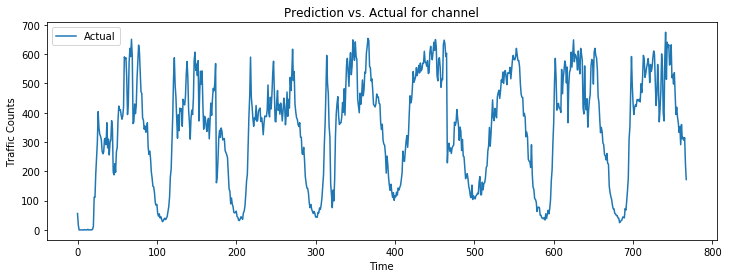

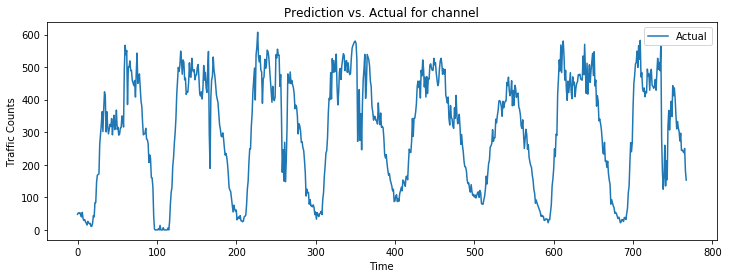

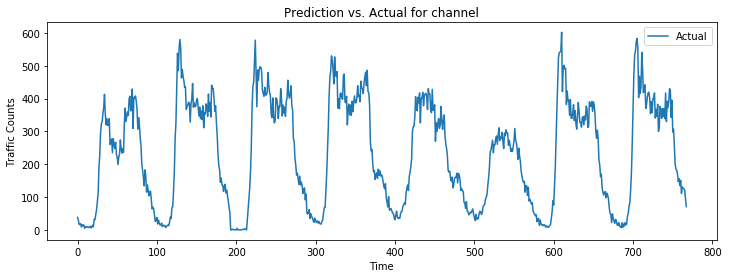

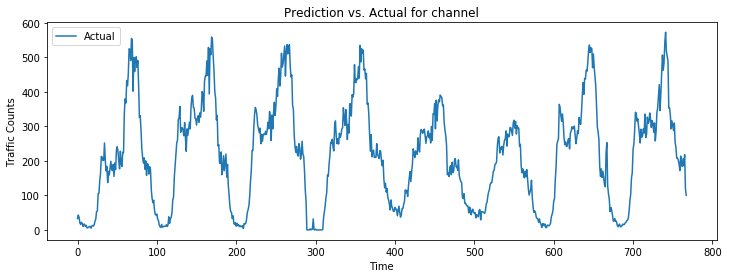

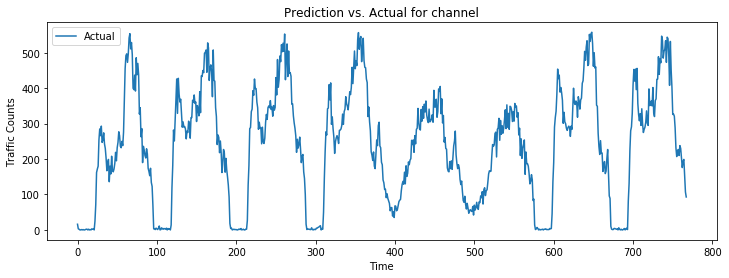

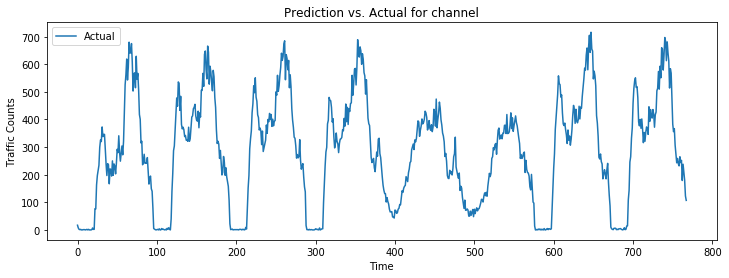

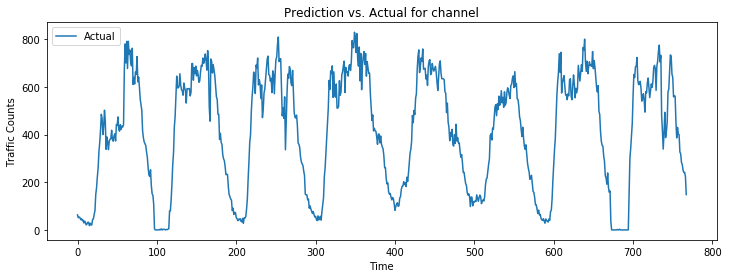

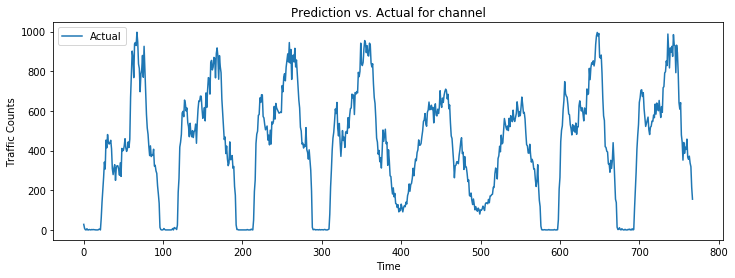

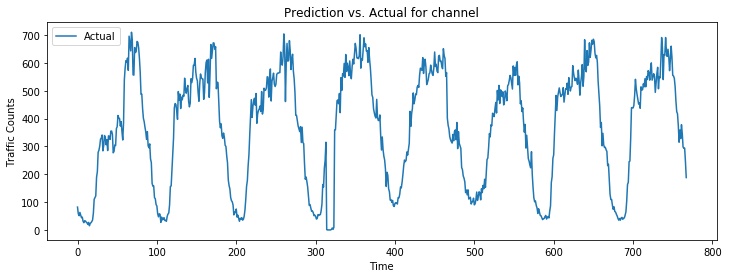

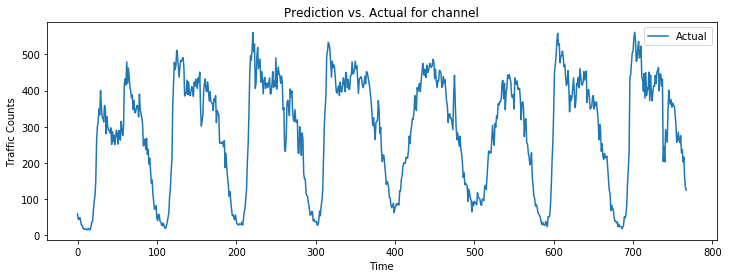

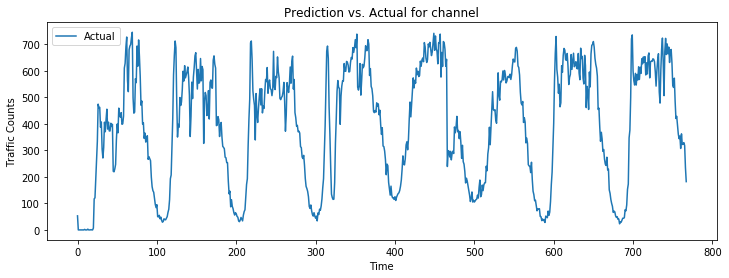

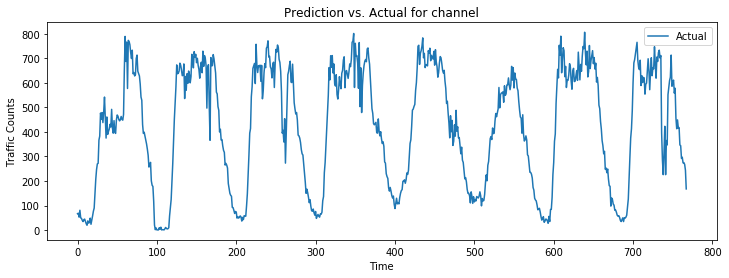

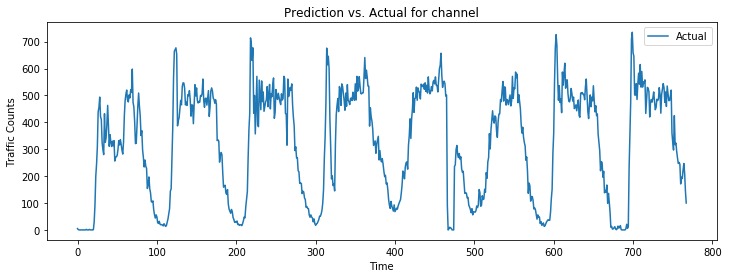

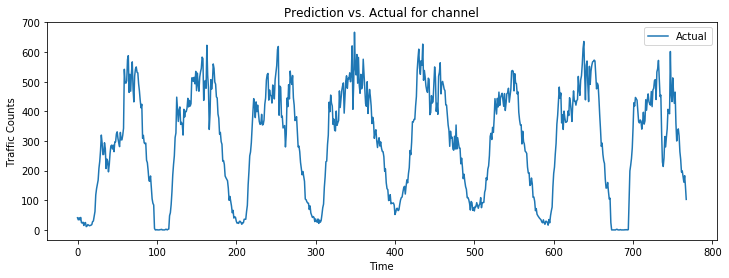

In [6]:
i = 0
for detector in lst_detectors:

    df_detector = df_dropped[df_dropped['detector_code'] == detector]

    df_detector = pd.merge(df_timestamps, df_detector, on=['start_time'], how='left')

    # impute the missing values of 'count' as 0
    df_detector['count'] = df_detector['count'].fillna(0.0)
    df_detector['detector_code'] = detector
    df_detector.drop_duplicates(inplace=True)
    df_detector = df_detector.reset_index(drop=True)

    df_count_15min = df_detector.groupby(df_detector.index // 15).sum()
    df_detector_15min = df_detector.groupby(df_detector.index // 15).tail(1).reset_index(drop=True)
    df_detector_15min = df_detector_15min.drop(['count'], axis=1)
    
    df_detector_15min = pd.merge(df_detector_15min, df_count_15min, left_index=True, right_index=True)
    
    # Create new attrbutes
    df_detector_15min['Totaal_delta_1'] = df_detector_15min[['count']].diff(periods=1)
    df_detector_15min['Totaal_delta_2'] = df_detector_15min[['count']].diff(periods=2)
    
    df_detector_15min['DateTime'] = pd.to_datetime(df_detector_15min['start_time'], dayfirst=True)
    df_detector_15min['Time'] = df_detector_15min.apply(lambda row: row['start_time'][-5:], axis=1)
    
    df_detector_15min['day_of_week'] = df_detector_15min['DateTime'].dt.day_name()
    df_detector_15min['is_weekday'] = (df_detector_15min['DateTime'].dt.day_name() != 'Saturday') & (df_detector_15min['DateTime'].dt.day_name() != 'Sunday')
    df_detector_15min['is_wednesday'] = df_detector_15min['DateTime'].dt.day_name() == 'Wednesday'
    df_detector_15min['is_rushhour'] = df_detector_15min['Time'].isin(rush_hours) 

    
    df_detector_15min = df_detector_15min.drop(['start_time', 'Time'], axis=1)
    df_detector_15min.rename(columns = {'count':'Totaal Abs.', 'detector_code': 'Detector_Code'}, inplace = True) 

    if i == 0:
        df_test = df_detector_15min

    else:
        df_test = df_test.append(df_detector_15min, ignore_index = True) 
    i += 1     

    
    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel', fontsize=12)
    plt.plot(df_detector_15min['Totaal Abs.'], label="Actual")
    plt.xlabel("Time")
    plt.ylabel("Traffic Counts")
    plt.legend()
    # plt.grid(True)
    plt.show()    

In [7]:
df_test.iloc[30:40, :]


,Detector_Code,Totaal Abs.,Totaal_delta_1,Totaal_delta_2,DateTime,day_of_week,is_weekday,is_wednesday,is_rushhour
30,ARL_103,308.0,-12.0,-19.0,2020-01-14 07:45:00,Tuesday,True,False,True
31,ARL_103,269.0,-39.0,-51.0,2020-01-14 08:00:00,Tuesday,True,False,True
32,ARL_103,260.0,-9.0,-48.0,2020-01-14 08:15:00,Tuesday,True,False,True
33,ARL_103,267.0,7.0,-2.0,2020-01-14 08:30:00,Tuesday,True,False,True
34,ARL_103,309.0,42.0,49.0,2020-01-14 08:45:00,Tuesday,True,False,True
35,ARL_103,313.0,4.0,46.0,2020-01-14 09:00:00,Tuesday,True,False,True
36,ARL_103,291.0,-22.0,-18.0,2020-01-14 09:15:00,Tuesday,True,False,False
37,ARL_103,366.0,75.0,53.0,2020-01-14 09:30:00,Tuesday,True,False,False
38,ARL_103,280.0,-86.0,-11.0,2020-01-14 09:45:00,Tuesday,True,False,False
39,ARL_103,310.0,30.0,-56.0,2020-01-14 10:00:00,Tuesday,True,False,False


In [12]:
def load_pickle(filename):
    d = None
    with open(filename, mode='rb') as f:
        d = pickle.load(f)
    return d

def get_weight_dicts(graph_file, lst_detectors):
    graph = load_pickle(graph_file)

    detector_to_edge = dict()
    lst_valid_detectors = []

    for u, v, edge_data in graph.edges(data=True):
        if 'detector_info' in edge_data:
            detector_info = edge_data['detector_info']
            detector_id = detector_info['id']
            if detector_id in lst_detectors:
                detector_to_edge[detector_id] = (u, v)
                lst_valid_detectors.append(detector_id)

    dict_in_weights = dict()
    for detector_id, (u, v) in detector_to_edge.items():
        dict_in_weights[detector_id] = dict()
        dict_weights = dict_in_weights[detector_id]
        for detector_id_n, (u_n, v_n) in detector_to_edge.items():
            # the channel itself and the opposite channel are not taken into account in computing neighbouring influence
            if detector_id == detector_id_n:
            # if detector_id == detector_id_n:
                dict_weights[detector_id_n] = 0.0
            else:
                try:
                    path = nx.shortest_path(graph, source=v_n, target=u, weight='length')
                    path_length_meters = sum([graph.get_edge_data(path[i], path[i + 1])['length']
                                              for i in range(len(path) - 1)])
                    if path_length_meters == 0:
                        dict_weights[detector_id_n] = 1.0
                    else:
                        dict_weights[detector_id_n] = 1.0 / path_length_meters
                except nx.NetworkXNoPath:
                    dict_weights[detector_id_n] = 0.0

    dict_out_weights = dict()
    for detector_id, (u, v) in detector_to_edge.items():
        dict_out_weights[detector_id] = dict()
        dict_weights = dict_out_weights[detector_id]
        for detector_id_n, (u_n, v_n) in detector_to_edge.items():
            # the channel itself and the opposite channel are not taken into account in computing neighbouring influence
            if detector_id == detector_id_n:
            # if detector_id == detector_id_n:
                dict_weights[detector_id_n] = 0.0
            else:
                try:
                    path = nx.shortest_path(graph, source=v, target=u_n, weight='length')
                    path_length_meters = sum([graph.get_edge_data(path[i], path[i + 1])['length']
                                              for i in range(len(path) - 1)])
                    if path_length_meters == 0:
                        dict_weights[detector_id_n] = 1.0
                    else:
                        dict_weights[detector_id_n] = 1.0 / path_length_meters
                except nx.NetworkXNoPath:
                    dict_weights[detector_id_n] = 0.0

    return lst_valid_detectors, dict_in_weights, dict_out_weights                    


# Load the graph from a pickle file, and get the incoming/outgoing weights for each detector
graph_file = '../data/brussels_graph.bin'

valid_detectors, weights_in, weights_out = get_weight_dicts(graph_file, lst_detectors)

In [29]:
def series_to_supervised(data, target, n_lags=1, n_leads=0, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a Pandas DataFrame.
        tareget: List of the target column names.
        n_lags: Number of lags for the observations (X). (n>=1; time steps: [-n,-n+1,..., -1] )
        n_leads: Number of time steps ahead for the prediction (y). (n>=0; time step: n; 0 is the index of "now")
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame for supervised learning.
    """

    df_tars = data[[target]]
    df_vars = data

    n_tars = df_tars.shape[1]
    n_vars = data.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lags, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t+n)
    if n_leads == 0:
        cols.append(df_tars)
        names += [('tar%d(t)' % (j + 1)) for j in range(n_tars)]
    else:
        cols.append(df_tars.shift(-n_leads))
        names += [('tar%d(t+%d)' % (j + 1, n_leads)) for j in range(n_tars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def get_features_neighbouring_channels(df, channel, lst_valid_channels, weights):
    """
    Get vehicle count features from the data for neighbouring channels,
    by using the weights on the edges of the graph.
    """

    # get the DateTime series of the data for the channel being processed
    df_temp = df[df['Detector_Code'] == channel]
    df_neighbours = df_temp[['DateTime']]

    dict_weights_for_ch = weights[channel]
    i = 0
    column_list = []
    for other_ch in dict_weights_for_ch:
        # Get the vehicle count features for a different channel
        df_other_ch = df[df['Detector_Code'] == other_ch]
        if df_other_ch.shape[0] == 0 or other_ch == channel:
            continue
        df_other_ch = df_other_ch[['DateTime', 'Totaal Abs.']]
        df_other_ch['Weighted_Total'] = df_other_ch['Totaal Abs.'] * dict_weights_for_ch[other_ch]
        df_other_ch = df_other_ch.drop(['Totaal Abs.'], axis=1)
        df_other_ch.columns = ['DateTime', 'W_Total_n_' + str(i)]
        column_list.append('W_Total_n_' + str(i))
        # Join the vehicle count features for other detectors at each time stamp
        df_neighbours = pd.merge(df_neighbours, df_other_ch, on=['DateTime'], how='left')
        i += 1

    # df_neighbours.set_index('DateTime')

    df_neighbours['sum'] = df_neighbours[column_list].sum(axis=1)
    df_neighbours['max'] = df_neighbours[column_list].max(axis=1)
    # df_neighbours['min'] = df_neighbours[column_list].min(axis=1)
    df_neighbours['avg'] = df_neighbours[column_list].mean(axis=1)
    df_neighbours['std'] = df_neighbours[column_list].std(axis=1)

    df_neighbours_features = df_neighbours.drop(column_list, axis=1)

    return df_neighbours_features


def prepare_graph_based_features(df, lst_valid_detectors, weights_in, weights_out):

    dict_test_df = {}

    for detector in lst_valid_detectors:
        # Get the data for the specific channel
        df_for_detector = df[df['Detector_Code'] == detector]

        # For some channels, the data extraction time range is different from others.
        # Such channels have been removed in the imported dataframe.
        if df_for_detector.shape[0] == 0:
            continue

        # Get the vehicle count features from the data for other channels
        df_other_channels_in = get_features_neighbouring_channels(df, detector, lst_valid_detectors, weights_in)
        df_other_channels_in.columns = ['DateTime', 'sum_in', 'max_in', 'avg_in', 'std_in']

        df_other_channels_out = get_features_neighbouring_channels(df, detector, lst_valid_detectors, weights_out)
        df_other_channels_out.columns = ['DateTime', 'sum_out', 'max_out', 'avg_out', 'std_out']

        df_enriched = pd.merge(df_for_detector, df_other_channels_in, on=['DateTime'], how='left')
        df_enriched = pd.merge(df_enriched, df_other_channels_out, on=['DateTime'], how='left')

        # Drop the columns that are not used for training
        col_to_drop = ['Detector_Code', 'day_of_week']
        df_enriched = df_enriched.drop(col_to_drop, axis=1)

        test_x_axis = df_enriched['DateTime']
        test_x_arr = test_x_axis.apply(str).to_numpy()[num_timesteps + pred_steps:]
        
        # print(df_enriched.head())

        # Create the multivariate feature set with historical window for the test set
        df_enriched_test = df_enriched.drop(['DateTime'], axis=1)
        
        columns_reorder = ['Totaal Abs.', 'Totaal_delta_1', 'Totaal_delta_2', 'is_weekday', 'is_wednesday', 'is_rushhour', 
                           'sum_in', 'max_in', 'avg_in', 'std_in', 'sum_out', 'max_out', 'avg_out', 'std_out']
        
        df_enriched_test = df_enriched_test.reindex(columns=columns_reorder)
        
        num_feaures = df_enriched_test.shape[1]
        
        df_windowed_test = series_to_supervised(df_enriched_test, 'Totaal Abs.', n_lags=num_timesteps,
                                               n_leads=pred_steps, dropnan=True)

        # Add the test set to the return dict
        dict_test_df[detector] = (test_x_arr, df_windowed_test)

    return num_feaures, dict_test_df




# Construct the build and test sets for different months
num_feaures, dict_df_test = prepare_graph_based_features(df_test, valid_detectors, weights_in, weights_out)


In [31]:
# load model and scaler from files
model_file = "../models/xgbRegressor_hasselt.bin"
scaler_file = "../models/scaler_hasselt.pkl"
loaded_model = pickle.load(open(model_file, "rb"))
loaded_scaler = pickle.load(open(scaler_file, "rb"))

[15:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### For every detector, generate the 30 min prediction by using the Hasselt PureTSM model and detector data-specific scaler

Test RMSE: 76.220
Test R^2: 0.740


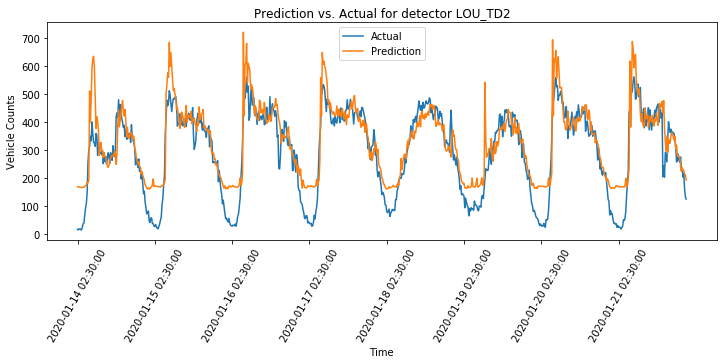

Test RMSE: 99.790
Test R^2: 0.758


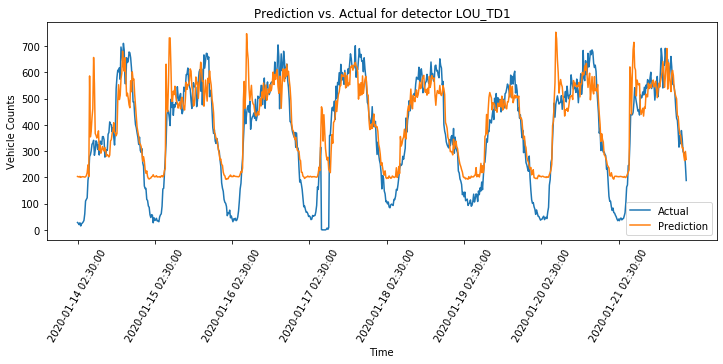

Test RMSE: 111.965
Test R^2: 0.618


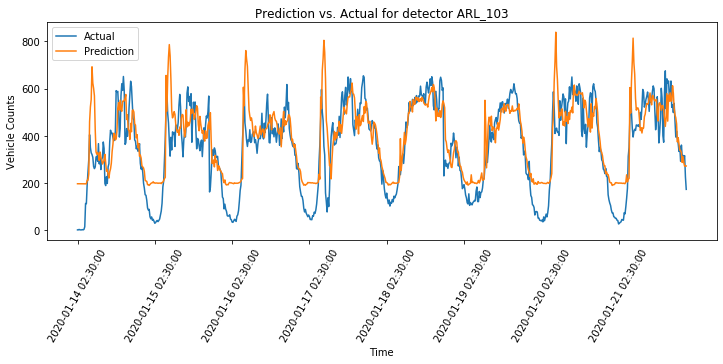

Test RMSE: 66.504
Test R^2: 0.794


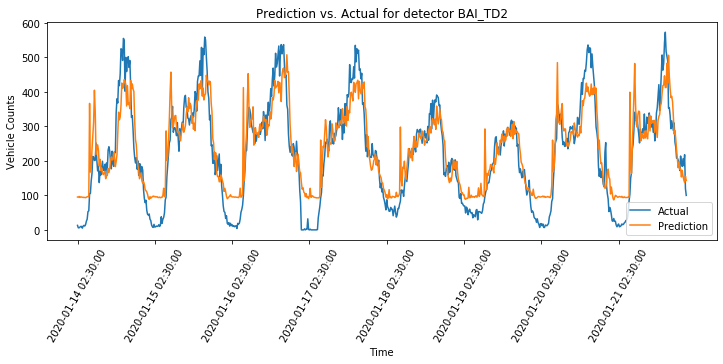

Test RMSE: 62.757
Test R^2: 0.846


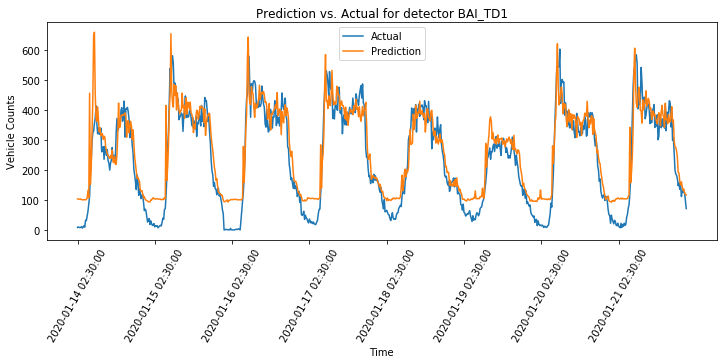

Test RMSE: 112.118
Test R^2: 0.783


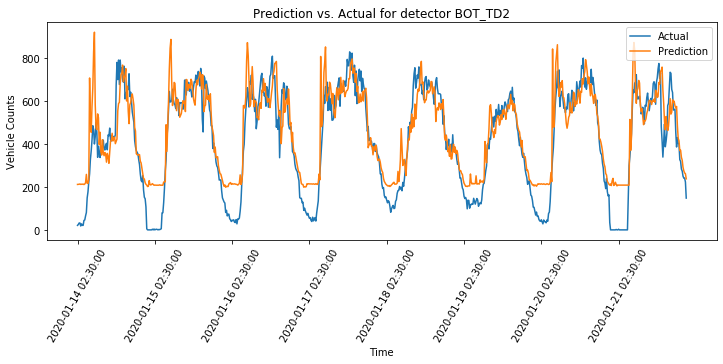

Test RMSE: 69.812
Test R^2: 0.801


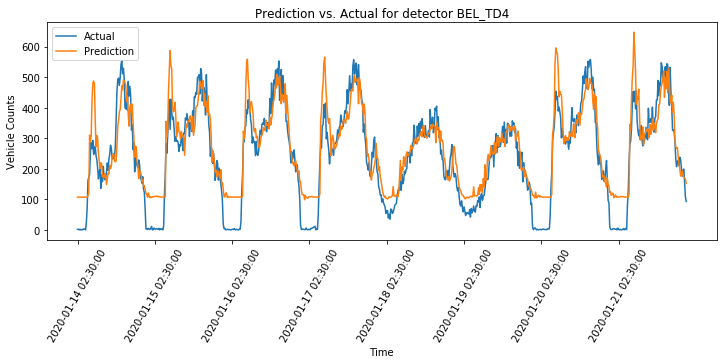

Test RMSE: 123.520
Test R^2: 0.674


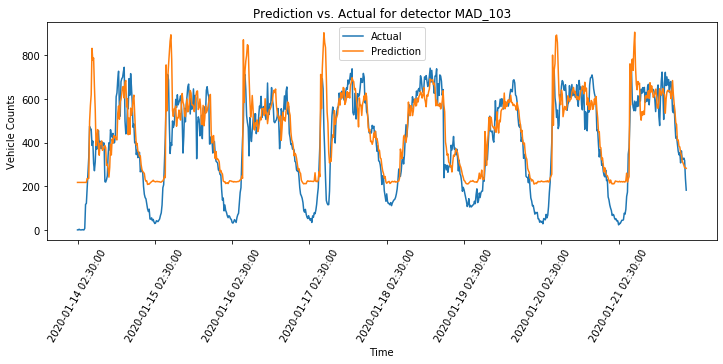

Test RMSE: 115.003
Test R^2: 0.766


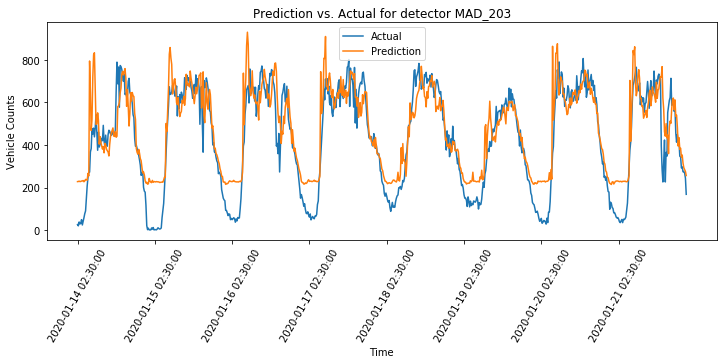

Test RMSE: 82.753
Test R^2: 0.758


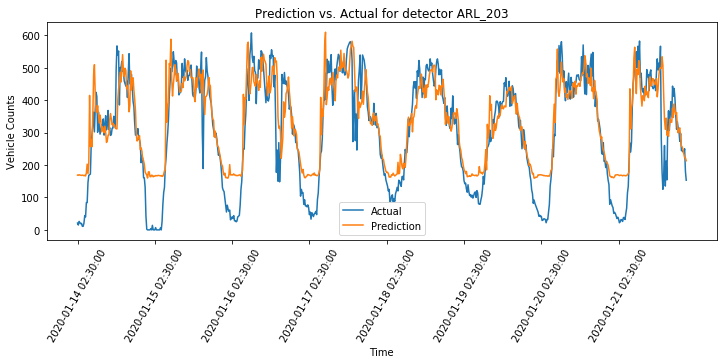

Test RMSE: 127.451
Test R^2: 0.788


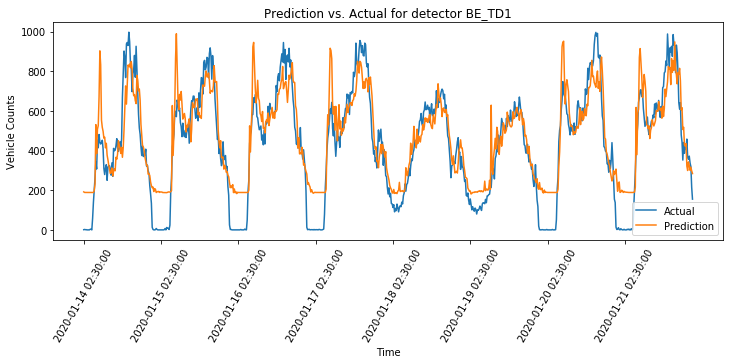

Test RMSE: 83.509
Test R^2: 0.781


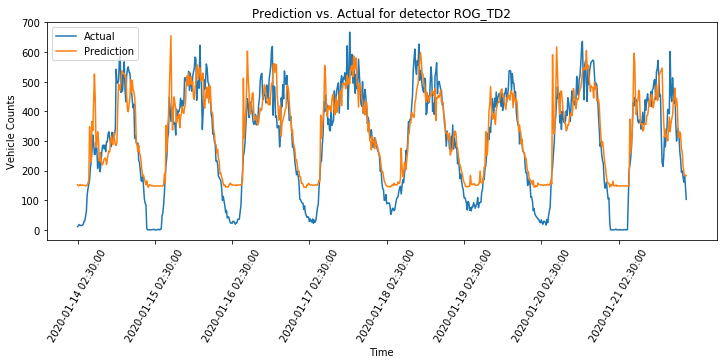

Test RMSE: 103.184
Test R^2: 0.729


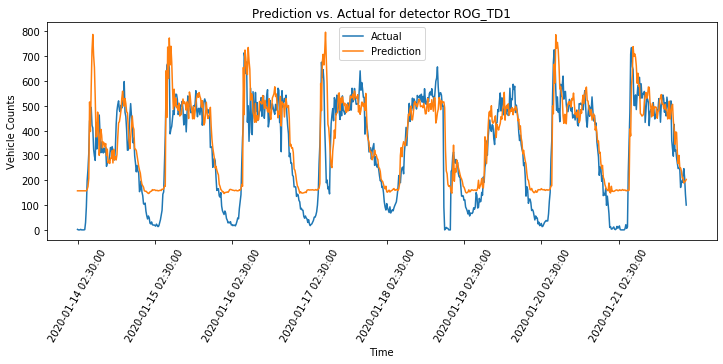

Test RMSE: 82.766
Test R^2: 0.812


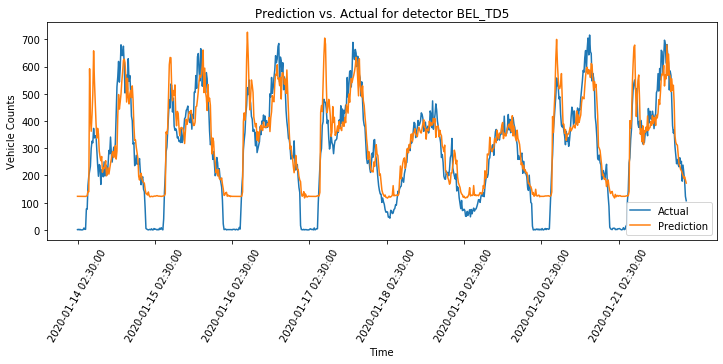

In [32]:
# Create the time series for each channel and pre-process the data
for detector in dict_df_test:
    
    test_x_arr = dict_df_test[detector][0]
    df_detector = dict_df_test[detector][1]

    df_test_f32 = df_detector.astype('float32')
    
    scaler = StandardScaler()
    data_arr_test = scaler.fit_transform(df_test_f32)
    
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    
    # ---------------- Make a prediction on the test set and evaluate the rusult. 
    test_y_pred = loaded_model.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for detector {detector}', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=96),test_x_arr[::96], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Vehicle Counts")
    plt.legend()
    # plt.grid(True)
    plt.show()  